# Text classification with Transformer
- 비윤리적 문장 탐지 트랜스포머 모델
- 컴퓨터공학종합프로젝트2
- 전남대학교 컴퓨터정보통신공학 182571 윤현서

## 1. 환경설정

### 1-1. 라이브러리

In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 8.3MB/s 


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import drive
import sentencepiece as spm
import pandas as pd
import numpy as np
import os
import gzip
import shutil

### 1-2. 버전 확인

In [ ]:
print(tf.__version__)
print(pd.__version__)
print(np.__version__)

2.5.0
1.1.5
1.19.5


### 1-3. GPU 확인

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## 2. 데이터 전처리

### 2-1. 데이터 로드

In [ ]:
drive.mount('/content/drive')
# data를 저장할 폴더 입니다. 환경에 맞게 수정 하세요.
data_dir = "/content/drive/My Drive/Capstone2/"

Mounted at /content/drive


In [ ]:
train = pd.read_csv(data_dir+"bias_data_train.csv")
test = pd.read_csv(data_dir+"bias_data_test.csv")

print(train.shape)
print(test.shape)

(50222, 2)
(4974, 2)


### 2-2. 데이터 전처리
- 문장 인코딩

In [ ]:
def data_preprocessing(train, test):
    vocab_file = f"{data_dir}/kowiki.model"
    vocab = spm.SentencePieceProcessor()
    vocab.load(vocab_file)

    '''
    # 데이터 인코딩 테스트
    lines = [
        "겨울이 되어서 날씨가 무척 추워요.",
        "이번 성탄절은 화이트 크리스마스가 될까요?",
        "겨울에 감기 조심하시고 행복한 연말 되세요."
            ]
    for line in lines:
    pieces = vocab.encode_as_pieces(line)
    ids = vocab.encode_as_ids(line)
    print(line)
    print(pieces)
    print(ids)
    print()
    '''

    x_train = train["comments"]
    y_train = train["label"]
    x_test = test["comments"]
    y_test = test["label"]

    for l in range(len(x_train)):
        x_train[l] = vocab.encode_as_ids(x_train[l])

    for l in range(len(x_test)):
        x_test[l] = vocab.encode_as_ids(x_test[l])
    
    y_train = np.asarray(y_train).astype('float32')
    y_test = np.asarray(y_test).astype('float32')

    return x_train, y_train, x_test, y_test

In [ ]:
x_train, y_train, x_test, y_test = data_preprocessing(train, test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


- 문장 패딩

In [ ]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review

In [ ]:
print(len(x_train), "Training sequences")
print(len(x_test), "Test sequences")
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

50222 Training sequences
4974 Test sequences


## 3. 모델

### 3-1. Transformer
- Transformer 블록을 레이어로 사용

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

- 임베딩 레이어

In [ ]:

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


### 3-2. 모델 구현 함수

In [ ]:
def make_model(maxlen, vocab_size):

    embed_dim = 32  # Embedding size for each token
    num_heads = 2  # Number of attention heads
    ff_dim = 32  # Hidden layer size in feed forward network inside transformer

    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(16, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(2, activation="softmax")(x)
    
    return keras.Model(inputs=inputs, outputs=outputs)

### 3-3. 모델 실행 함수

In [ ]:
def model_run(model, x_train, y_train, checkpoint_path, optimizer="adam"):
  epochs = 500
  batch_size = 16

  callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path, save_weights_only=True, verbose=1, save_best_only=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001, mode='min'
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, verbose=1),
  ]
  model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
  )
  history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
  )

### 3-4. 모델 학습

In [ ]:
# 모델 저장 경로
model_dir = data_dir+"model_Trans3/"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

# 체크포인트 파일 저장 경로
checkpoint_path = model_dir+"checkpoints_model_trans3.ckpt"

In [ ]:
model = make_model(maxlen, vocab_size)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
token_and_position_embedding (None, 200, 32)           646400    
_________________________________________________________________
transformer_block (Transform (None, 200, 32)           10656     
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0     

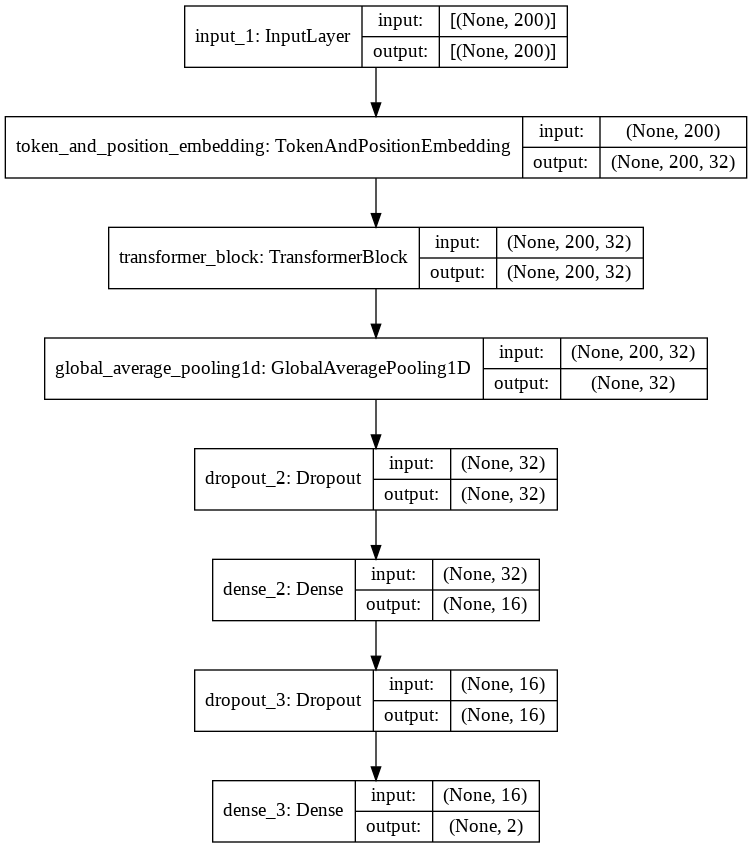

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')
plot_model(model, to_file='model_shapes.png', show_shapes=True)

In [ ]:
model_run(model, x_train, y_train, checkpoint_path, optimizer="adam")

Epoch 1/500
2512/2512 [==============================] - 32s 11ms/step - loss: 0.2982 - sparse_categorical_accuracy: 0.8674 - val_loss: 0.2525 - val_sparse_categorical_accuracy: 0.9107

Epoch 00001: val_loss improved from inf to 0.25249, saving model to /content/drive/My Drive/Capstone2/model_Trans3/checkpoints_model_trans3.ckpt
Epoch 2/500
2512/2512 [==============================] - 28s 11ms/step - loss: 0.2266 - sparse_categorical_accuracy: 0.9013 - val_loss: 0.3272 - val_sparse_categorical_accuracy: 0.8215

Epoch 00002: val_loss did not improve from 0.25249
Epoch 3/500
2512/2512 [==============================] - 28s 11ms/step - loss: 0.2018 - sparse_categorical_accuracy: 0.9096 - val_loss: 0.2178 - val_sparse_categorical_accuracy: 0.9198

Epoch 00003: val_loss improved from 0.25249 to 0.21779, saving model to /content/drive/My Drive/Capstone2/model_Trans3/checkpoints_model_trans3.ckpt
Epoch 4/500
2512/2512 [==============================] - 29s 11ms/step - loss: 0.1856 - sparse_ca

## 4. 성능 평가

### 4-1. 성능 평가 함수

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

In [ ]:
def evalution(x_test, y_test, model):

    # data_pre = model.predict(x_test)
    # print(data_pre)
    pred_roc = model.predict(x_test)
    pred_z = []
    for j in range(len(pred_roc)):
        pred_z.append(list(pred_roc[j]).index(max(list(pred_roc[j]))))

    pred_z = np.asarray(pred_z).astype('float32')

    y_test_z = y_test
    # y_test_z[y_test_z == i] = -1
    # y_test_z[y_test_z >= 0] = 0
    # y_test_z[y_test_z < 0] = 1

    # print(pred_z)
    # print(y_test)

    print(accuracy_score(y_test_z,pred_z))
    print(precision_score(y_test_z,pred_z))
    print(recall_score(y_test_z,pred_z))
    print(roc_auc_score(y_test_z,pred_z))

    # test_loss, test_acc = model.evaluate(x_test, y_test)

    # print("Test accuracy", test_acc)
    # print("Test loss", test_loss)

### 4-2. 모델 로드

In [ ]:
model = make_model(maxlen, vocab_size)
model.load_weights(checkpoint_path)
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

### 4-3. 모델 성능 평가

In [ ]:
evalution(x_test, y_test, model)

0.9201849618013671
0.994449806949807
0.9167964404894327
0.9343898695140275


In [ ]:
line_input = []
line_input.append("사람 완치 됐고 문제는 티그가 아닌 씨오투 용접사였는데 마스크 따위 일절 쓰고 하다가 지경 된거 ㅋㅋㅋ 요즘 마스크 조올라 좋지 짱깨발 문세먼지도 확실히 ㅁㅈㅎ시켜주고")

In [ ]:
lines = pd.DataFrame({"comments":list(line_input), "label": [0]})

In [ ]:
line_test = lines.copy()

In [ ]:
_, _, line_x, _ = data_preprocessing(line_test, lines)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
line_x = keras.preprocessing.sequence.pad_sequences(line_x, maxlen=maxlen)

In [ ]:
pred = model.predict(line_x)
pred

array([[0.12366773, 0.8763322 ]], dtype=float32)